# Problem 3: Weight Initialization and Dead neurons

## Problem 3.1: Initializations

### Utils.py 

In [1]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras import backend as K

from matplotlib import pyplot as plt
from matplotlib import rcParamsDefault


def grid_axes_it(n_plots, n_cols=3, enumerate=False, fig=None):
    """
    Iterate through Axes objects on a grid with n_cols columns and as many
    rows as needed to accommodate n_plots many plots.
    Args:
        n_plots: Number of plots to plot onto figure.
        n_cols: Number of columns to divide the figure into.
        fig: Optional figure reference.
    Yields:
        n_plots many Axes objects on a grid.
    """
    n_rows = n_plots / n_cols + int(n_plots % n_cols > 0)

    if not fig:
        default_figsize = rcParamsDefault['figure.figsize']
        fig = plt.figure(figsize=(
            default_figsize[0] * n_cols,
            default_figsize[1] * n_rows
        ))

    for i in range(1, n_plots + 1):
        ax = plt.subplot(n_rows, n_cols, i)
        yield ax


def create_mlp_model(
    n_hidden_layers,
    dim_layer,
    input_shape,
    n_classes,
    kernel_initializer,
    bias_initializer,
    activation,
):
    """Create Multi-Layer Perceptron with given parameters."""
    model = Sequential()
    model.add(Dense(dim_layer, input_shape=input_shape, kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer))
    for i in range(n_hidden_layers):
        model.add(Dense(dim_layer, activation=activation, kernel_initializer=kernel_initializer,
                        bias_initializer=bias_initializer))
    model.add(Dense(n_classes, activation='softmax', kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer))
    return model


def create_cnn_model(input_shape, num_classes, kernel_initializer='glorot_uniform',
                     bias_initializer='zeros'):
    """Create CNN model similar to
       https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py."""
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,
                     kernel_initializer=kernel_initializer,
                     bias_initializer=bias_initializer))
    model.add(Conv2D(64, (3, 3), activation='relu',
                     kernel_initializer=kernel_initializer,
                     bias_initializer=bias_initializer))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu',
                    kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax',
                    kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer))
    return model


def compile_model(model):
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.RMSprop(),
                  metrics=['accuracy'])
    return model


def get_init_id(init):
    """
    Returns string ID summarizing initialization scheme and its parameters.
    Args:
        init: Instance of some initializer from keras.initializers.
    """
    try:
        init_name = str(init).split('.')[2].split(' ')[0]
    except:
        init_name = str(init).split(' ')[0].replace('.', '_')

    param_list = []
    config = init.get_config()
    for k, v in config.items():
        if k == 'seed':
            continue
        param_list.append('{k}-{v}'.format(k=k, v=v))
    init_params = '__'.join(param_list)

    return '|'.join([init_name, init_params])


def get_activations(model, x, mode=0.0):
    """Extract activations with given model and input vector x."""
    outputs = [layer.output for layer in model.layers]
    activations = K.function([model.input], outputs)
    output_elts = activations([x, mode])
    return output_elts


class LossHistory(keras.callbacks.Callback):
    """A custom keras callback for recording losses during network training."""

    def on_train_begin(self, logs={}):
        self.losses = []
        self.epoch_losses = []
        self.epoch_val_losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

    def on_epoch_end(self, epoch, logs={}):
        self.epoch_losses.append(logs.get('loss'))
        self.epoch_val_losses.append(logs.get('val_loss'))

Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

## 3.1: Plotting Activations to explain vanishing and exploding gradients

In [3]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from keras import initializers
from keras.datasets import mnist

In [4]:
# Data Preparation

seed = 10

n_train = 60000
n_test = 10000

(x_train, y_train), (x_test, y_test) = mnist.load_data()
num_classes = len(np.unique(y_test))
data_dim = 28 * 28

x_train = x_train.reshape(60000, 784).astype('float32')[:n_train]
x_test = x_test.reshape(10000, 784).astype('float32')[:n_train]
x_train /= 255
x_test /= 255

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

11493376/11490434 [==============================] - 1s 0us/step


In [5]:
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(60000, 784) (60000, 10) (10000, 784) (10000, 10)


In [60]:
# Run the data through a few MLP models and save the activations from
# each layer into a Pandas DataFrame.

# Network params
def train_network(activation, init)->pd.DataFrame:
    n_train = 60000
    n_test = 10000
    n_hidden_layers = 5
    dim_layer = 100
    batch_size = n_train
    epochs = 1
    n_train = 1000
    n_test = 100
    n_classes = 10

    rows = []

    model = create_mlp_model(
        n_hidden_layers,
        dim_layer,
        (data_dim,),
        n_classes,
        init,
        'zeros',
        activation
        )
    compile_model(model)
    output_elts = get_activations(model, x_test)
    n_layers = len(model.layers)
    i_output_layer = n_layers - 1

    for i, out in enumerate(output_elts[:-1]):
        if i > 0 and i != i_output_layer:
            for out_i in out.ravel()[::20]:
                rows.append([i, stddev, out_i])
    
    df = pd.DataFrame(rows, columns=['Hidden Layer', 'Standard Deviation', 'Output'])
    return df

In [61]:
def plot(df,activation,initializer):
    fig = plt.figure(figsize=(12, 6))
    axes = grid_axes_it(len(sigmas), 1, fig=fig)
    
    ax = next(axes)
    ddf = df[df['Standard Deviation'] == sig]
    sns.violinplot(x='Hidden Layer', y='Output', data=ddf, ax=ax, scale='count', inner=None)

    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.set_title('Activation Funtion: '+activation+', Initializer: '+initializer, fontsize=13)

    if sig == sigmas[1]:
        ax.set_ylabel(activation+" Neuron Outputs")
    if sig != sigmas[-1]:
        ax.set_xticklabels(())
    else:
        ax.set_xlabel("Hidden Layer")
    
    plt.tight_layout()
    plt.show()

### Tanh and Sigmoid Functions:

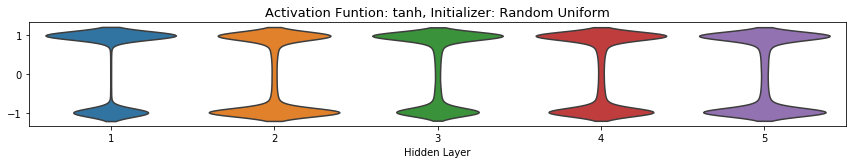

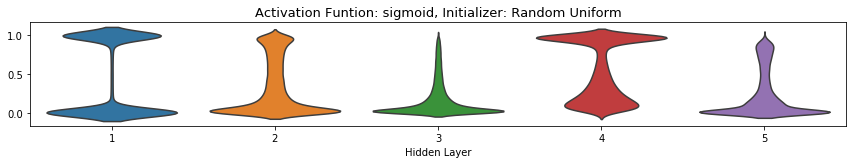

In [55]:
init = initializers.RandomUniform(-1,1,seed=seed)

df = train_network('tanh',init)
plot(df,'tanh','Random Normal')

df = train_network('sigmoid',init)
plot(df,'sigmoid','Random Uniform')

# Plot previously saved activations from the 5 hidden layers
# using different initialization schemes.


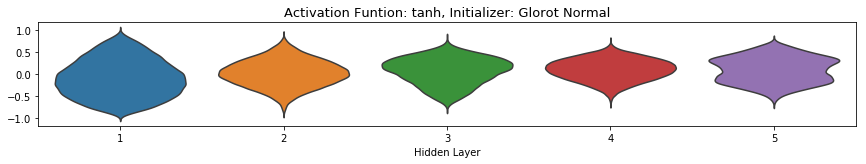

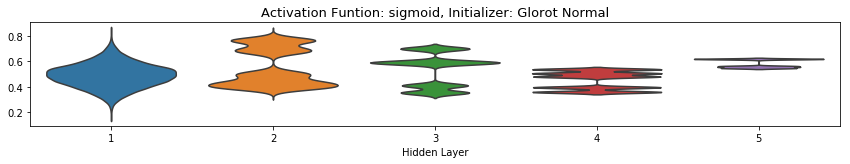

In [57]:
#Using Glorot Normal Initialization on Tanh and Sigmoid
init = initializers.glorot_normal(seed=seed)

df = train_network('tanh',init)
plot(df,'tanh','Glorot Normal')

df = train_network('sigmoid',init)
plot(df,'sigmoid','Glorot Normal')

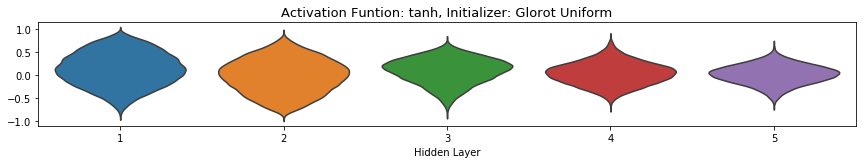

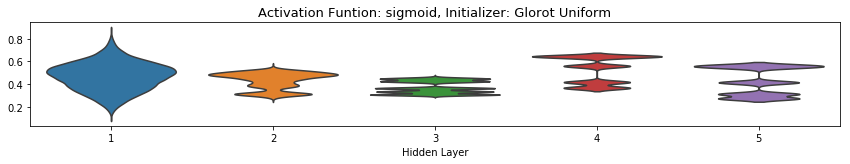

In [58]:
#Using Glorot Uniform Initialization on Tanh and Sigmoid
init = initializers.glorot_uniform(seed=seed)

df = train_network('tanh',init)
plot(df,'tanh','Glorot Uniform')

df = train_network('sigmoid',init)
plot(df,'sigmoid','Glorot Uniform')

Comparing the three graphs above, we can clearly see that using Glorot Normal or Glorot Uniform initialization of weights deals with the vanishing/exploding gradient problem, represented as a very uneven distributuion of weights (with concentrations of very high density and some with very low density without normalization).

### Relu as activation function:

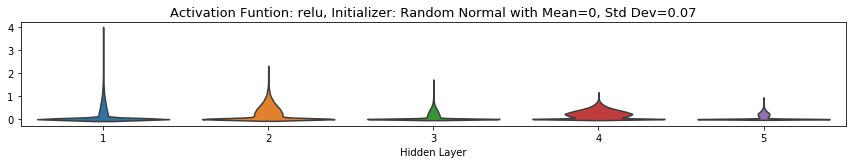

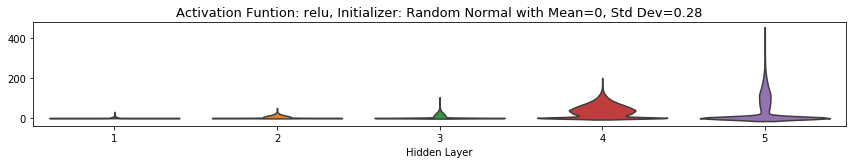

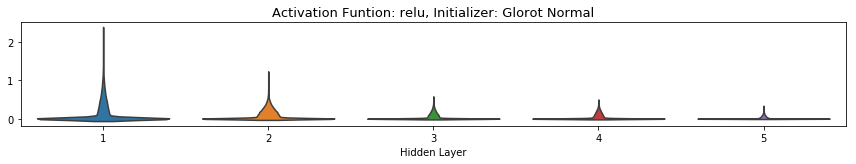

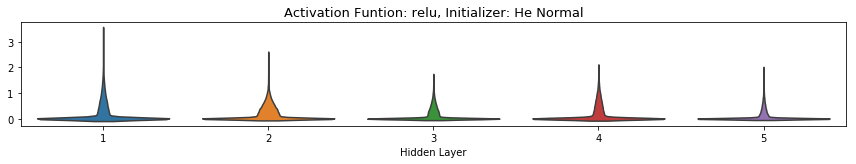

In [64]:
init = initializers.RandomNormal(mean=0,stddev=0.1,seed=seed)
df = train_network('relu',init)
plot(df,'relu','Random Normal with Mean=0, Std Dev=0.07')

init = initializers.RandomNormal(mean=0,stddev=0.28,seed=seed)
df = train_network('relu',init)
plot(df,'relu','Random Normal with Mean=0, Std Dev=0.28')

init = initializers.glorot_normal(seed=seed)
df = train_network('relu',init)
plot(df,'relu','Glorot Normal')

init = initializers.he_normal(seed=seed)
df = train_network('relu',init)
plot(df,'relu','He Normal')

Comparing the three plots above: We can see that with normal initialization, using ReLu as an activation function results in exploding gradients for smaller variance, and vanishing gradients for a bigger inappropriate variance. Using Glorot initialization does give a marginally better performance when compared to Random Normal, the gradients are still vanishing as they propagate down the layers.

The best option is to use He Initialization, where the gradients stay within a specific range. This ensures our large networks do not "die" in one of the middle layers, thus producing a zero output.

## Problem 3.2 Finding no. of dead networks in a 1000 runs with ReLU

In [4]:
from math import sqrt,sin

import numpy as np
import matplotlib.pyplot as plt

from keras.optimizers import RMSprop,Adagrad,Adadelta,Adam,Nadam
from keras.models import Sequential
from keras.layers import Dense
import keras.layers as layers
from keras import regularizers
from keras.initializers import RandomNormal
import keras.backend as K

In [6]:
x = np.random.uniform(-1*sqrt(7),sqrt(7),(3000,1))
y = np.array([xi*sin(xi) for xi in x])
y.reshape(len(y),1)

array([[1.18925469],
       [1.36958199],
       [0.05087685],
       ...,
       [0.10885904],
       [0.04787605],
       [1.80105318]])

In [7]:
print(x.shape, len(y))

(3000, 1) 3000


In [8]:
model = Sequential()
model.add(Dense(1, input_dim=1, activation='relu', use_bias=False))
for i in range(9):
    model.add(Dense(2, activation='relu', use_bias=False))
model.add(Dense(1,activation='linear',use_bias=False))

model.compile(optimizer='Adam', loss='mean_squared_error')

In [13]:
collapse = 0

for i in range(1000):
    if i%100 == 0:
        print(i)
    model.fit(x, y, batch_size=64, epochs=10, verbose=0)

    if (model.predict([0.5]) == model.predict([0.05]) and model.predict([0.15]) == model.predict([0.05]) and model.predict([0.15]) == model.predict([1]) and model.predict([0.15]) == model.predict([1.5])):
        collapse+=1

0
100
200
300
400
500
600
700
800
900


In [16]:
print(collapse/1000)

0.956


## 3.3 Finding no. of dead networks in a 1000 runs with LeakyReLu

In [20]:
from keras.layers.advanced_activations import LeakyReLU

model = Sequential()
model.add(Dense(1, input_dim=1, use_bias=False))
model.add(LeakyReLU(alpha=0.1))
for i in range(9):
    model.add(Dense(2, use_bias=False))
    model.add(LeakyReLU(alpha=0.1))
model.add(Dense(1,activation='linear',use_bias=False))

model.compile(optimizer='Adam', loss='mean_squared_error')

In [21]:
collapse = 0

for i in range(1000):
    if i%100 == 0:
        print(i)
    model.fit(x, y, batch_size=64, epochs=10, verbose=0)

    if (model.predict([0.5]) == model.predict([0.05]) and model.predict([0.15]) == model.predict([0.05]) and model.predict([0.15]) == model.predict([1]) and model.predict([0.15]) == model.predict([1.5])):
        collapse+=1

0
100
200
300
400
500
600
700
800
900


In [25]:
print(collapse/1000)

0.192


It is clearly seen that using leaky ReLU reduces the number of dead networks by a vast number.